In [1]:
# Homework 5 Solutions
# Mass Profiles
# G. Besla & H. Foote

In [2]:
# import modules
import numpy as np
import astropy.units as u
import astropy.constants as const

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from GalaxyMass import ComponentMass

In [3]:
class MassProfile:
    '''Class that measures and plots mass profiles and rotation curves of
    simulation snapshots'''
    
    def __init__(self, galaxy, snap):
        ''' This class reads snapshots and plots the mass profiles 
        and rotation curves of galaxies.

        PARAMETERS
        ----------
        galaxy : `str; 'MW', 'M31', or 'M33'`
                Name of the galaxy to read in
        snap : `int`
            Number of the snapshot to read in
        '''
        
        # Determine Filename
        # add a string of the filenumber to the value "000"
        ilbl = '000' + str(snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        # create filenames
        self.filename='%s_'%(galaxy) + ilbl + '.txt'
        
        # read the particle data                                                                                             
        self.time, self.total, self.data = Read(self.filename)

        # store the mass, positions, velocities of all particles                                
        self.m = self.data['m']#*u.Msun
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
    
        # store galaxy name
        self.gname = galaxy
    
        # converting G to units of kpc*km^2/s^2/Msun
        self.G = const.G.to(u.kpc*u.km**2/u.s**2/u.Msun) 
    
    
    def massEnclosed(self, ptype, radii):
        '''This method computes and returns the mass profile of the galaxy
        based on the specified particle type.

        PARAMETERS
        ----------
        ptype : `int; 1, 2, or 3`
            particle type
        radii : `np.ndarray`
            array of radius bin edges, in kpc

        RETURNS
        -------
        m_enc : `np.ndarray`
            array containing the mass within the radii specified 
            by r, in Msun
        '''
    
        # Determine the COM position using Disk Particles
        # Disk Particles afford the best centroiding.
        # Create a COM object
        com = CenterOfMass(self.filename,2)
        # Store the COM position of the galaxy
        # Set Delta = whatever you determined to be a 
        #good value in Homework 4.
        com_pos = com.COM_P(0.1)
            
        # create an array to store indexes of particles of desired Ptype                                                
        index = np.where(self.data['type'] == ptype)

        # Store positions of particles of given ptype from the COMP. 
        xG = self.x[index] - com_pos[0]
        yG = self.y[index] - com_pos[1]
        zG = self.z[index] - com_pos[2]
            
        # Compute the mag. of the 3D radius
        rG = np.sqrt(xG**2 + yG**2 + zG**2)
            
        # store mass of particles of a given ptype
        mG = self.m[index]
            
        # Array to store enclosed mass as a function of the 
        #input radius array
        m_enc = np.zeros(np.size(radii))
        # equivalently: 
        # m_enc = np.zeros_like(radii)
    
        # loop through the radii array
        for i in range(np.size(radii)):
            # Only want particles within the given radius
            indexR = np.where(rG <  radii[i]*u.kpc)
            m_enc[i] = np.sum(mG[indexR])         
        
        # return the array of enclosed mass with appropriate units
        return m_enc*u.Msun*1e10
        
    
    def massEnclosedTotal(self, radii):    
        '''This method computes and returns the mass profile of 
        the galaxy based on ALL particles.

        PARAMETERS
        ----------
        radii : `np.ndarray`
            array of radius bin edges, in kpc

        RETURNS
        -------
        m_enc : `np.ndarray`
            array containing the mass within the radii
            specified by r, in Msun
        '''
     
        # Sum up all the mass of each component.
        m_enc = self.massEnclosed(1,radii) + self.massEnclosed(2,radii) + self.massEnclosed(3,radii)
    
        # Recall that M33 only has 2 components!  No bulge
        if (self.gname == 'M33'):
            m_enc = self.massEnclosed(1,radii)+ self.massEnclosed(2,radii)  
          
        return m_enc
    
        
        
    def hernquistMass(self, r, a, mhalo):
        ''' This method returns the mass enclosed within a radius based on
        the analytic Hernquist density profile.

        PARAMETERS
        ----------
        r : `float` 
            radius to compute mass within in kpc
        a : `float`
            Hernquist profile scale radius in kpc
        mhalo : `astropy.Quantity`
            total halo mass in Msun

        RETURNS
        -------
        m_enc : `astropy.Quantity'
            mass enclosed by r in Msun
        '''

        # adding units
        r = r*u.kpc
        a = a*u.kpc
        
        # compute numerator and denominator separately
        A = mhalo * r**2
        B = (a + r)**2
        
        return A/B
       
        
        
        
    def circularVelocity(self, ptype, radii):
        '''This method computes and returns the rotation curve of the galaxy
        based on the specified particle type.
    
        PARAMETERS
        ----------
        ptype : `int; 1, 2, or 3`
            particle type
        radii : `np.ndarray`
            array of radius bin edges, in kpc

        RETURNS
        -------
        v_circ : `np.ndarray`
            array containing the circular orbital velocity at
            the radii specified by r, in km/s
        '''
    
        # compute the mass enclosed for the given ptype
        m_enc = self.massEnclosed(ptype,radii)
        
        # Determine the circular speed as a function of 
        # input radius assuming spherical symmetry 
        # note that radius needs units 
        # This will return units of kpc/Gyr
        v_circ = np.sqrt(self.G*m_enc/(radii*u.kpc))
        
        # round and return the array in km/s
        return np.around(v_circ.to(u.km/u.s), 2)
    
    
    def circularVelocityTotal(self, radii):
        '''This method computes and returns the rotation curve 
        of the galaxy based on ALL particles.

        PARAMETERS
        ----------
        radii : `np.ndarray`
            array of radius bin edges, in kpc

        RETURNS
        -------
        v_circ : `np.ndarray`
            array containing the circular orbital velocity at
            the radii specified by r, in km/s

        '''
    
        # compute the total mass enclosed
        m_enc = self.massEnclosedTotal(radii)
        
        # Determine the circular speed 
        # note that radii need units . 
        #This will return units of kpc/Gyr 
        v_circ = np.sqrt(self.G*m_enc/(radii*u.kpc))
        
        # round and return the circular speed in km/s
        return np.around(v_circ.to(u.km/u.s), 2)
    
    
    
    def hernquistVCirc(self, radii, a, mhalo):
        '''This method returns the mass enclosed within a radius based on
        the analytic Hernquist density profile.

        PARAMETERS
        ----------
        r : `float` 
            radius to compute mass within in kpc
        a : `float`
            Hernquist profile scale radius in kpc
        Mhalo : `astropy.Quantity`
            total halo mass in Msun

        RETURNS
        -------
        v_circ : `np.ndarray'
            circular orbital velocity at r in km/s
        '''
           
        # Store the enclosed mass 
        m_enc = self.hernquistMass(radii,a,mhalo)
    
        # Circular speed using enclosed mass 
        # Note: You could also write this analytically without 
        #first calling HernquistMass
        v_circ = np.sqrt(self.G*m_enc/(radii*u.kpc))
        
        # Return circular speed, rounded and in km/s
        return np.around(v_circ.to(u.km/u.s), 2)
    

In [4]:
# Create MassProfile Objects for each Galaxy

MW = MassProfile("MW",0)
M31 = MassProfile("M31",0)
M33 = MassProfile("M33",0)

# Testing Code

In [5]:
# TESTING
###############

# test Radius
RR = 30

# array of radii, not starting at 0.
# intervals of 1 kpc
testR = np.arange(0.1,RR+1,1.0)


In [6]:
# Testing Code and Hernquist Halo Match
# MW at 30 kpc
######################################

# scale radius to test
ScaleMW = 61
# total Halo Mass from M31
MtotMW = ComponentMass("MW_000.txt",1)*u.Msun*1e12
# Mass enclosed from simulation
MtestMW = MW.massEnclosed(1,testR)

#Mass enclosed from Hernquist Profile  
HtestMW = np.round(MW.hernquistMass(RR,ScaleMW,MtotMW)/1e10,2)


# Circular Velocity using mass enclosed from simulation
VtestMW = MW.circularVelocity(1,testR)

# Circular Velocity from hernquist profile
HVtestMW = MW.hernquistVCirc(RR,ScaleMW,MtotMW)

print("Testing MW at 30 kpc")
print("********************")
print("Scale Radius", ScaleMW)
print(np.round(MtestMW[RR]/1e10),"x 1e10")
print("Hernquist", HtestMW, "x 1e10")
print(" ")
print(VtestMW[RR])
print("Hernquist Vc",HVtestMW)

Testing MW at 30 kpc
********************
Scale Radius 61
21.0 solMass x 1e10
Hernquist 21.46 solMass x 1e10
 
173.78 km / s
Hernquist Vc 175.42 km / s


In [7]:
# Testing Code and Hernquist Halo Match
# M31 at 30 kpc
########################################

# scale radius to test
ScaleM31 = 62
# total Halo Mass of M31 from Assignment 3
MtotM31 = ComponentMass("M31_000.txt",1)*u.Msun*1e12


# Mass enclosed from simulation
MtestM31 = M31.massEnclosed(1,testR)

#Mass enclosed from Hernquist Profile  
HtestM31 = np.round(M31.hernquistMass(RR,ScaleM31, MtotM31)/1e10,2)


# Circular Velocity using mass enclosed from simulation
VtestM31 = M31.circularVelocity(1,testR)

# Circular Velocity from hernquist profile
HVtestM31 = M31.hernquistVCirc(RR,ScaleM31, MtotM31)


print("Testing M31 at 30 kpc")
print("********************")
print("Scale Radius", ScaleM31)
print(np.round(MtestM31[RR]/1e10),"x 1e10")
print("Hernquist", HtestM31, "x 1e10")
print(" ")
print(VtestM31[RR])
print("Hernquist Vc",HVtestM31)

Testing M31 at 30 kpc
********************
Scale Radius 62
21.0 solMass x 1e10
Hernquist 20.43 solMass x 1e10
 
171.39 km / s
Hernquist Vc 171.13 km / s


In [8]:
# Testing Code and Hernquist Halo Match
# M33 at 30 kpc
########################################

# scale radius to test
ScaleM33 = 25
# total Halo Mass of M33 from Assignment 3
MtotM33 = ComponentMass("M33_000.txt",1)*u.Msun*1e12


# Mass enclosed from simulation
MtestM33 = M33.massEnclosed(1,testR)

#Mass enclosed from Hernquist Profile  
HtestM33 = np.round(M33.hernquistMass(RR,ScaleM33, MtotM33)/1e10,2)

# Circular Velocity using mass enclosed from simulation
VtestM33 = M33.circularVelocity(1,testR)

# Circular Velocity from hernquist profile
HVtestM33 = M33.hernquistVCirc(RR,ScaleM33, MtotM33)

print("Testing M33 at 30 kpc")
print("********************")
print("Scale Radius", ScaleM33)
print(np.round(MtestM33[RR]/1e10),"x 1e10")
print("Hernquist", HtestM33, "x 1e10")
print(" ")
print(VtestM33[RR])
print("Hernquist Vc",HVtestM33)

Testing M33 at 30 kpc
********************
Scale Radius 25
6.0 solMass x 1e10
Hernquist 5.56 solMass x 1e10
 
89.53 km / s
Hernquist Vc 89.31 km / s


# Making Plots

In [13]:
def mEncPlot(galaxy, snap, plot_name, a):
    '''
    Plots the total and component-wise mass profile of a galaxy, 
    along with the analytic expectation from the Hernquist profile.

    PARAMETERS
    ----------
    galaxy : `str; 'MW', 'M31', or 'M33'`
        Name of the galaxy to read in
    snap : `int`
        Number of the snapshot to read in
    plot_name : 'str'
        Filename to save the plot under
    a : `float`
        Hernquist scale radius for analytic plot
    '''

    # read in galaxy information
    mProf = MassProfile(galaxy, snap) # mass profile

    # finding filename 
    ilbl = '000' + str(snap) # pad snapshot number
    ilbl = ilbl[-3:] # cut off leading digits so we end up 
      #with a three-digit snap number
    filename='%s_'%(galaxy) + ilbl + '.txt'
        
    M_halo_tot = ComponentMass(filename, 1) * 1e12 * u.Msun 
        # halo mass in Msun

    # radius array in kpc
    r_arr = np.linspace(0.1, 30, 100)

    # calculate mass profiles
    m_halo = mProf.massEnclosed(1, r_arr)
    m_disk = mProf.massEnclosed(2, r_arr)
    if galaxy != 'M33' : 
        # M33 doesn't have a bulge, so skip this if needed
        m_bulge = mProf.massEnclosed(3, r_arr)
    m_tot = mProf.massEnclosedTotal(r_arr)

    # make plot
    fig, ax = plt.subplots()
    # lines
    ax.plot(r_arr, mProf.hernquistMass(r_arr, a, M_halo_tot), 
            c='cyan', label='Analytic Halo, a={} kpc'.format(a))
    ax.plot(r_arr, m_halo, c='b', linestyle=':', label='Halo')
    ax.plot(r_arr, m_disk, c='r', linestyle='-.', label='Disk')
    if galaxy != 'M33' : 
        # M33 doesn't have a bulge, so skip this if needed
        ax.plot(r_arr, m_bulge, c='g', linestyle='--', label='Bulge')
    ax.plot(r_arr, m_tot, c='k', linewidth=3, label='Total')
    # other formatting 
    ax.set(xlabel='r [kpc]', ylabel='$M_{enc}$ $[M_\\odot]$', 
           yscale='log', ylim=[1e8, 5e11], title=galaxy+' Mass Profile')
    ax.legend()
    # save as image
    plt.savefig(plot_name)


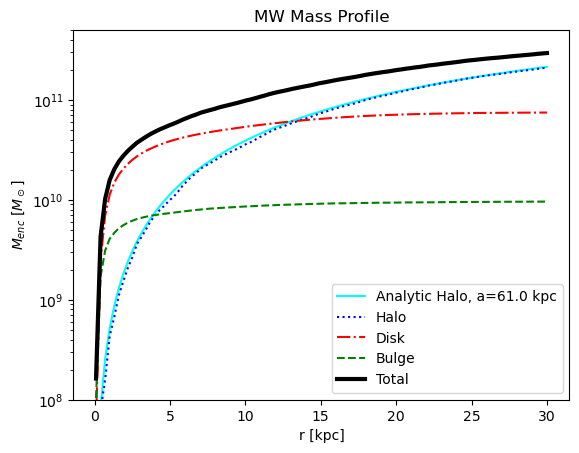

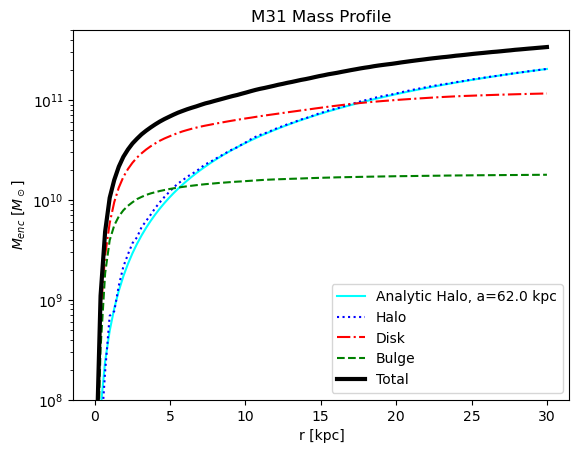

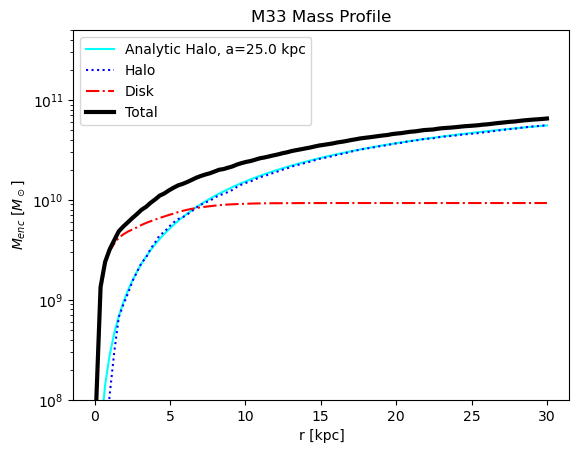

In [14]:
# plot mass profiles
mEncPlot('MW', 0, 'MW_mass.png', 61.)
mEncPlot('M31', 0, 'M31_mass.png', 62.)
mEncPlot('M33', 0, 'M33_mass.png', 25.)


In [11]:
def vCircPlot(galaxy, snap, plot_name, a):
    '''
    Plots the total and component-wise rotation curve of a galaxy, 
    along with the analytic expectation from the Hernquist profile.

    PARAMETERS
    ----------
    galaxy : `str; 'MW', 'M31', or 'M33'`
        Name of the galaxy to read in
    snap : `int`
        Number of the snapshot to read in
    plot_name : 'str'
        Filename to save the plot under
    a : `float`
        Hernquist scale radius for analytic plot
    '''

    # read in galaxy information
    mProf = MassProfile(galaxy, snap) # mass profile

    # finding filename 
    ilbl = '000' + str(snap) # pad snapshot number
    ilbl = ilbl[-3:] # cut off leading digits so we end 
        #up with a three-digit snap number
    filename='%s_'%(galaxy) + ilbl + '.txt'

    M_halo_tot = ComponentMass(filename, 1) * 1e12 * u.Msun 
    # halo mass in Msun

    # radius array in kpc
    r_arr = np.linspace(0.1, 30, 100)

    # calculate mass profiles
    v_halo = mProf.circularVelocity(1, r_arr)
    v_disk = mProf.circularVelocity(2, r_arr)
    if galaxy != 'M33' : 
        # M33 doesn't have a bulge, so skip this if needed
        v_bulge = mProf.circularVelocity(3, r_arr)
    v_tot = mProf.circularVelocityTotal(r_arr)

    # make plot
    fig, ax = plt.subplots()
    
    # lines
    ax.plot(r_arr, mProf.hernquistVCirc(r_arr, a, M_halo_tot), 
            c='cyan', label='Analytic Halo, a={} kpc'.format(a))
    ax.plot(r_arr, v_halo, c='b', linestyle=':', label='Halo')
    ax.plot(r_arr, v_disk, c='r', linestyle='-.', label='Disk')
    if galaxy != 'M33' : 
        # M33 doesn't have a bulge, so skip this if needed
        ax.plot(r_arr, v_bulge, c='g', linestyle='--', label='Bulge')
    ax.plot(r_arr, v_tot, c='k', linewidth=3, label='Total')
    # other formatting 
    ax.set(xlabel='r [kpc]', ylabel='$v_{circ}$ [km/s]', 
           title=galaxy+' Rotation Curve')
   
    ax.legend(loc="lower right")
    # save as image
    plt.savefig(plot_name)
    

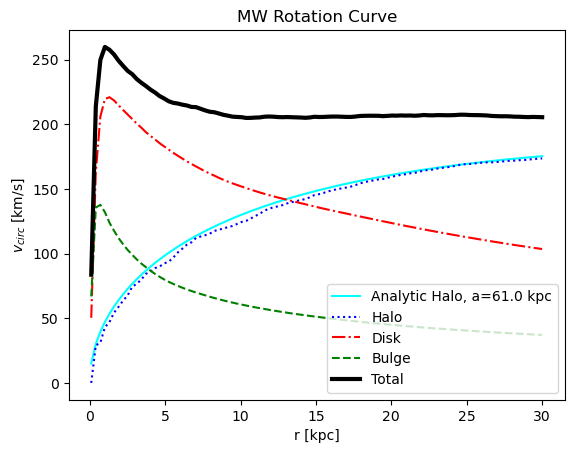

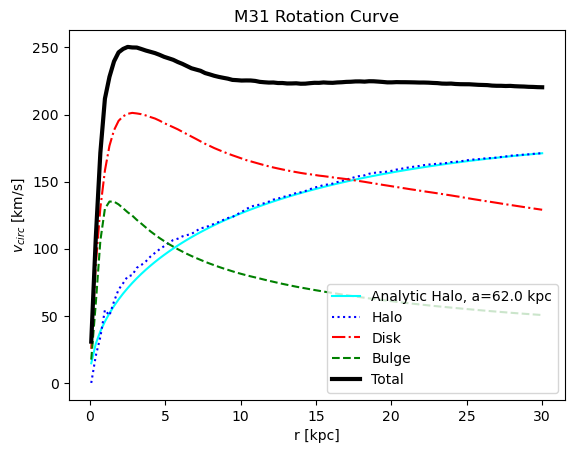

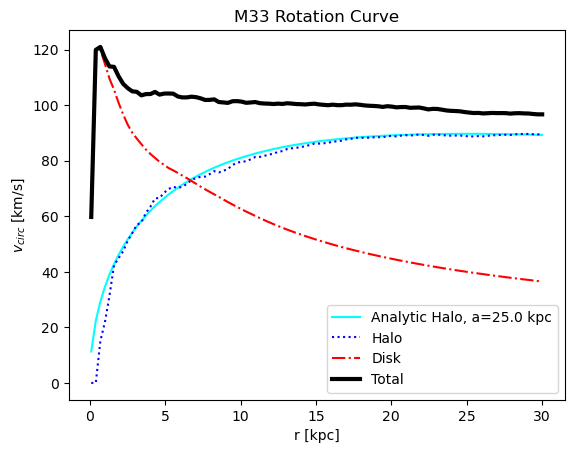

In [12]:
# plot rotation curves
vCircPlot('MW', 0, 'MW_rotcurve.png', 61.)
vCircPlot('M31', 0, 'M31_rotcurve.png', 62.)
vCircPlot('M33', 0, 'M33_rotcurve.png', 25.)